In [56]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [57]:
# 하이퍼파라미터 정의

embedding_dim = 128
dropout_prob = (0.5, 0.8)
num_filters = 128

In [58]:
data = pd.read_csv("./data/df.csv")
data

,Unnamed: 0,content,label
0,0,이종석 한효주 나오는 드라마 이후로 드라마 안봤다. 2년전인가?? 좀 신선했었지. ...,0
1,1,씨바알..노무노무 술프노... 오늘 저녁은 꽂등심이다ㅠㅜ,0
2,2,짱깨 꺼라ㅡ패쓰,0
3,3,그들의 사생활 ~ 고인이된 설리를 위해서라도 모두 조용하길 지금 누굴 탓한다고 무슨...,1
4,4,아무리 법이 뭣같아도 무슨 자격으로 개인의 신상정보를 불특정 다수에게 공개하는지 도...,1
...,...,...,...
17891,17891,힘내세요~ 응원합니다!!,1
17892,17892,힘내세요~~삼가 고인의 명복을 빕니다..,1
17893,17893,힘내세용 ^^ 항상 응원합니닷 ^^ !,1
17894,17894,힘내소...연기로 답해요.나도 53살 인데 이런일 저런일 다 있더라구요.인격을 믿습...,1


In [59]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size = 0.25, shuffle=True, random_state = 0)

<AxesSubplot:>

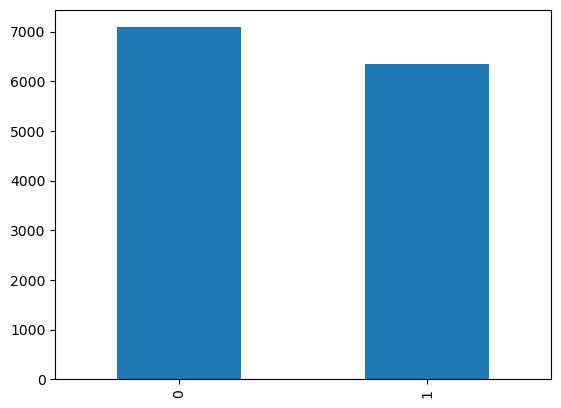

In [60]:
train['label'].value_counts().plot(kind = 'bar')

In [61]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

okt = Okt()
X_train = []
for sentence in train['content']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [62]:
print(X_train[:3])

[['여자', '분', '게임', '방송국', '에서', '일', '분', '방송인', '인데', '연예인', '그렇다', '맞다', 'ㅋㅋ'], ['여름', '덥다', '예정', '이고', '겨울', '추다', '예정', '이며', '눈', '올', '전망', '이다', '.'], ['한국', '여자', '진짜', '존나', '게', '맞다', '함']]


In [63]:
X_test = []
for sentence in test['content']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [64]:
#정수 인코딩 단어 집합 생성

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

print(tokenizer.word_index)

{'.': 1, '?': 2, '..': 3, '보다': 4, '...': 5, '을': 6, '아니다': 7, '있다': 8, '다': 9, '되다': 10, '없다': 11, 'ㅋㅋ': 12, '같다': 13, '안': 14, '좋다': 15, '로': 16, '만': 17, '사람': 18, '이다': 19, '못': 20, '왜': 21, '고': 22, '여자': 23, '에서': 24, '나': 25, '진짜': 26, '나오다': 27, '들다': 28, '그렇다': 29, '아': 30, '너무': 31, '~': 32, '네': 33, '하고': 34, '그': 35, '니': 36, '가다': 37, '게': 38, 'ㅋㅋㅋ': 39, '저': 40, '지': 41, '더': 42, '말': 43, '많다': 44, '먹다': 45, '거': 46, '뭐': 47, '!': 48, '때': 49, '않다': 50, '애': 51, '남자': 52, '인': 53, '그냥': 54, '새끼': 55, '라': 56, '알다': 57, '인데': 58, '것': 59, '이쁘다': 60, '야': 61, '면': 62, '적': 63, '개': 64, '돈': 65, '내': 66, '모르다': 67, '치다': 68, '생각': 69, '받다': 70, '자다': 71, '까지': 72, '??': 73, '오다': 74, '지다': 75, '씨': 76, '~~': 77, '....': 78, '랑': 79, 'ㅋ': 80, '한테': 81, '이나': 82, '기사': 83, '하': 84, '결혼': 85, '맞다': 86, ',': 87, '일': 88, '연기': 89, '또': 90, '냐': 91, '얼굴': 92, '보고': 93, '살다': 94, '드라마': 95, '놈': 96, '넘다': 97, '임': 98, '이렇다': 99, '년': 100, '요': 101, '나다': 102, '차다': 103, '해주다': 104

In [66]:
# 등장 빈도수가 3회 미만인 단어들의 비중 확인

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 16226
등장 빈도가 2번 이하인 희귀 단어의 수: 9279
단어 집합에서 희귀 단어의 비율: 57.18599778133859
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.775508015655997


In [67]:
# 등장 빈도수가 2이하인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한

# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 6948


In [68]:
# 정수 인코딩 실행

tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [35]:
print(X_train[:3])

[[23, 158, 1536, 937, 24, 88, 158, 5554, 58, 117, 29, 86, 12], [3058, 938, 4572, 185, 5555, 821, 4572, 3403, 263, 1113, 10306, 19, 1], [106, 23, 26, 140, 38, 86, 179]]


In [70]:
# train_data에서 y_train과 y_test를 별도로 저장

y_train = np.array(train['label'])
y_test = np.array(test['label'])

리뷰의 최대 길이 : 247
리뷰의 평균 길이 : 12.954328714051558


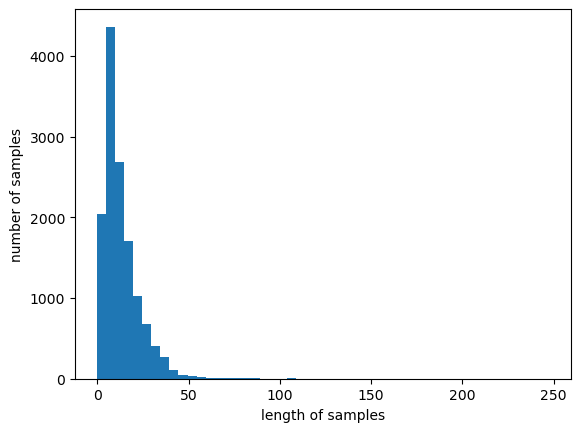

In [71]:
# 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포 확인

print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [36]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [21]:

max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 92.43778870511102


In [74]:
# 모든 샘플의 길이를 30으로 맞춰 패딩

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [72]:
# 각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스를 받아오기

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print(len(X_train))
print(len(y_train))

13416
13416


C:\Users\nana\anaconda3\lib\site-packages\numpy\lib\function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [75]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [76]:
embedding_dim = 128
dropout_prob = (0.5, 0.8)
num_filters = 128

In [77]:
# 입력 층과 임베딩 층을 정의, 50% 드롭아웃

model_input = Input(shape = (max_len,))
z = Embedding(vocab_size, embedding_dim, input_length = max_len, name="embedding")(model_input)
z = Dropout(dropout_prob[0])(z)

In [78]:
# 3, 4, 5의 크기를 가지는 커널을 각각 128개 사용합니다. 그리고 이들을 maxpooling

conv_blocks = []

for sz in [3, 4, 5]:
    conv = Conv1D(filters = num_filters,
                         kernel_size = sz,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)

In [79]:
# maxpooling한 결과를 연결(concatenate) 그리고 이를 밀집 층(dense layer)으로 연결

z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_prob[1])(z)
z = Dense(128, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)

model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

In [52]:
import numpy as np
X_train = np.array(X_train)
X_test = np.array(X_test)

In [80]:
# maxpooling한 결과를 연결(concatenate) 그리고 이를 밀집 층(dense layer)으로 연결

z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_prob[1])(z)
z = Dense(128, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)

model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

In [81]:
# 이진 분류 수행

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('CNN_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.fit(X_train, y_train, batch_size = 64, epochs=10, validation_data = (X_test, y_test), verbose=2, callbacks=[es, mc])

Epoch 1/10

Epoch 1: val_acc improved from -inf to 0.78721, saving model to CNN_model.h5
210/210 - 19s - loss: 0.6317 - acc: 0.6243 - val_loss: 0.4491 - val_acc: 0.7872 - 19s/epoch - 90ms/step
Epoch 2/10

Epoch 2: val_acc improved from 0.78721 to 0.82767, saving model to CNN_model.h5
210/210 - 13s - loss: 0.4095 - acc: 0.8133 - val_loss: 0.3815 - val_acc: 0.8277 - 13s/epoch - 64ms/step
Epoch 3/10

Epoch 3: val_acc improved from 0.82767 to 0.83460, saving model to CNN_model.h5
210/210 - 13s - loss: 0.3114 - acc: 0.8702 - val_loss: 0.3667 - val_acc: 0.8346 - 13s/epoch - 64ms/step
Epoch 4/10

Epoch 4: val_acc improved from 0.83460 to 0.83549, saving model to CNN_model.h5
210/210 - 14s - loss: 0.2437 - acc: 0.9034 - val_loss: 0.3961 - val_acc: 0.8355 - 14s/epoch - 66ms/step
Epoch 5/10

Epoch 5: val_acc improved from 0.83549 to 0.84578, saving model to CNN_model.h5
210/210 - 14s - loss: 0.2108 - acc: 0.9148 - val_loss: 0.3953 - val_acc: 0.8458 - 14s/epoch - 65ms/step
Epoch 6/10

Epoch 6: va

In [82]:
# 테스트 데이터에 대해 정확도 평가

loaded_model = load_model('CNN_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

140/140 [==============================] - 2s 10ms/step - loss: 0.3953 - acc: 0.8458

 테스트 정확도: 0.8458


In [83]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 일반댓 입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 악플댓 입니다.\n".format((1 - score) * 100))

In [84]:
sentiment_predict('짱나')

1/1 [==============================] - 0s 266ms/step
63.97% 확률로 일반댓 입니다.



In [85]:
sentiment_predict('짜증나')

1/1 [==============================] - 0s 48ms/step
64.15% 확률로 일반댓 입니다.



In [86]:
sentiment_predict('미친놈이다')

1/1 [==============================] - 0s 75ms/step
91.52% 확률로 악플댓 입니다.



In [88]:
sentiment_predict('너 이새끼')

1/1 [==============================] - 0s 35ms/step
99.86% 확률로 악플댓 입니다.



In [89]:
sentiment_predict('아름답다')

1/1 [==============================] - 0s 61ms/step
99.58% 확률로 일반댓 입니다.



In [90]:
sentiment_predict('진짜 재수 ')

1/1 [==============================] - 0s 56ms/step
66.68% 확률로 악플댓 입니다.



In [91]:
sentiment_predict('정말 싫어 ')

1/1 [==============================] - 0s 84ms/step
74.45% 확률로 일반댓 입니다.

